In [ ]:
pip install pyEDFlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyedflib import highlevel
import pyedflib as plib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import csv
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score

#Filtering
##notch

In [ ]:
# prompt: Write a path variable which has a shared google drive
import os
path = '/content/drive/MyDrive/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R03.edf'
signals, signal_headers, header = highlevel.read_edf(path)

In [ ]:
path = "/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R03.edf"
path = "/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R03.edf"
# path = '/content/drive/MyDrive/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R03.edf'
signals, signal_headers, header = highlevel.read_edf(path)
t = np.linspace(0, 125, num=20000)

f0 = 50.0  # Frequency to be removed from the signal (in Hz)
Q = 30.0  # Quality factor
fs = 160
nyquist = 0.5 * fs  # Nyquist frequency (Hz)

b_notch, a_notch = signal.iirnotch(f0, Q, fs)

# Apply the notch filter to the signal
filtered_signal = signal.lfilter(b_notch, a_notch, signals[1, :])

# Plot original and filtered signals
# plt.figure(figsize=(10, 6))
# plt.plot(t, signals[1, :], label='Original Signal')
# plt.plot(t, filtered_signal, label='Filtered Signal')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.title('Notch Filter')
# plt.legend()
# plt.grid(True)
# plt.show()

#bandpass

In [ ]:
# Define sampling frequency and Nyquist frequency

# Define bandpass filter specifications
low_cutoff = 0.5 / nyquist  # Low cutoff frequency (normalized)
high_cutoff = 70 / nyquist  # High cutoff frequency (normalized)
order = 4  # Filter order

# Design IIR bandpass filter
b_bp, a_bp = signal.iirfilter(order, [low_cutoff, high_cutoff], btype='band', ftype='butter')

# Apply the notch filter to the signal
filtered_signal = signal.lfilter(b_bp, a_bp, filtered_signal)


# Plot original and filtered signals
# plt.figure(figsize=(10, 6))
# plt.plot(t, signals[1, :], label='Original Signal')
# plt.plot(t, filtered_signal, label='Filtered Signal')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.title('Band Filter')
# plt.legend()
# plt.grid(True)
# plt.show()

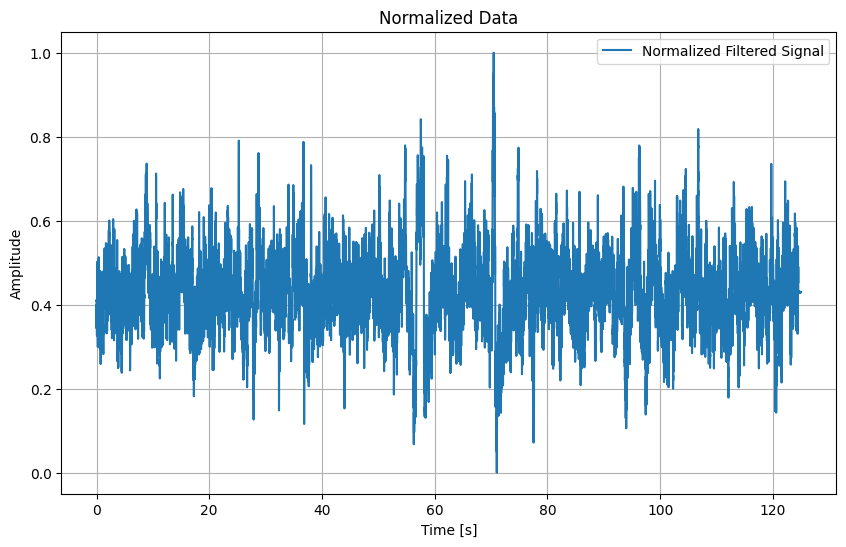

In [ ]:
def min_max_normalize(data):
    """
    Perform min-max normalization on the input data.

    Parameters:
    data (numpy.ndarray): Input data array.

    Returns:
    numpy.ndarray: Normalized data array.
    """
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data


normalized_filtered_data = min_max_normalize(filtered_signal)
plt.figure(figsize=(10, 6))
plt.plot(t, normalized_filtered_data, label='Normalized Filtered Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Normalized Data')
plt.legend()
plt.grid(True)
plt.show()

##Method 01

In [ ]:
left_right_fist = [4, 8, 12]
# datset to remove due to lower signal to noise ratio
subjects_to_omit = [43, 88, 89, 92, 100, 104]
# symmetric pairs defined by following research
# Lin YP, Wang CH, Jung TP, Wu TL, Jeng SK, Duann JR, Chen JH. EEG-based emotion recognition in music listening. IEEE Trans Biomed Eng. 2010 Jul;57(7):1798-806. doi: 10.1109/TBME.2010.2048568. Epub 2010 May 3. PMID: 20442037.
# symmetric_pairs = {"Fp1": "Fp2", "F7": "F8", "F3" : "F4", "FT7" : "FT8", "FC3" : "FC4", "T7" : "T8", ...
                  #  "P7" : "P8", "C3" : "C4", "TP7" : "TP8", "CP3" : "CP4", "P3" : "P4" , "O1" : "O2"}

#  Automated Classification of L/R Hand Movement EEG Signals using Advanced Feature Extraction and Machine Learning
# FC3, FCZ, FC4, C3, C1, CZ, C2, and C4
# S001, S002, S003, S004, S005, and S006

test_subjects = ["S001", "S002", "S003", "S004", "S005", "S006", "S007", "S008", "S009", "S010", "S011"]
test_subjects = ["S{0:03d}".format(i) for i in range(1,90) if i not in subjects_to_omit]
trial = [3, 4, 7, 8, 11, 12]

# Key-value pair to search for
key = 'label'
# Add Channels to include
channels = ['Fc3.', 'Fcz.', 'Fc4.', 'Fc3.', 'C1..', 'Cz..', 'C2..', 'C4..']

def find_indexes(data, key, value):
  indexes = []
  for i, item in enumerate(data):
      # print(item)
      if key in item.keys() and item[key] == value:
          indexes.append(i)
          return indexes
  else:
    print('Channel {} could not be found'.format(value))
    return indexes

no_of_samples = len(trial) * len(test_subjects)
no_channels = len(channels)
recording_length = 0
annotations = {'T0': 0 , 'T1': 1 , 'T2': 2 ,}

for test_subject_i in test_subjects:
  for trial_i in trial:
    path = "/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/{0}/{0}R{1:02d}.edf".format(test_subject_i, trial_i)
    # path = "/content/drive/MyDrive/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/{0}/{0}R{1:02d}.edf".format(test_subject_i, trial_i)
    # print(path)

    signals, signal_headers, header = highlevel.read_edf(path)

    recording_length = max(signals.shape[1], recording_length)

input_arr = np.zeros((no_of_samples, recording_length, no_channels), dtype=float)
output_arr = np.zeros((no_of_samples, recording_length, 1), dtype=float)

for t_index, test_subject_i in enumerate(test_subjects):
  for trainl_index, trial_i in enumerate(trial):
    path = "/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/{0}/{0}R{1:02d}.edf".format(test_subject_i, trial_i)
    # path = "/content/drive/MyDrive/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/{0}/{0}R{1:02d}.edf".format(test_subject_i, trial_i)
    print(path)

    signals, signal_headers, header = highlevel.read_edf(path)

    print(signals.shape)



    # Find indexes
    indexes = []

    for channel in channels:
      indexes.extend(find_indexes(signal_headers, key, channel))
    print(indexes)

    for target_i, source_i in enumerate(indexes):

      if recording_length > np.array(signals[source_i, :]).shape[0]:
        # input_arr[t_index*len(trial) + trainl_index,
        #           target_i,:] = np.pad(np.array(signals[source_i, :]),
        #                               int((recording_length - np.array(signals[source_i, :]).shape[0])/2),
        #                               'constant', constant_values=(0))

        for annotations_i in header['annotations']:
          if annotations_i[2] == 'T0' and annotations_i[1] *fs > recording_length - np.array(signals[source_i, :]).shape[0]:
            input_arr[t_index*len(trial) + trainl_index,
                  :,target_i] = np.concatenate((np.array(signals[source_i, :]),
                                               np.array(signals[source_i,
                                                                int(annotations_i[0] * fs):
                                                                recording_length - np.array(signals[source_i, :]).shape[0]] )))
            break
      else:
        input_arr[t_index*len(trial) + trainl_index,
                  :,target_i] = np.array(signals[source_i, :])


    # Apply the notch filter to the signal
    input_arr[t_index*len(trial) + trainl_index, :, :] = signal.lfilter(b_notch, a_notch, input_arr[t_index*len(trial) + trainl_index, :, :], axis=1)
    # Apply band pass filter to the signal
    input_arr[t_index*len(trial) + trainl_index, :, :] = signal.lfilter(b_bp, a_bp, input_arr[t_index*len(trial) + trainl_index, :, :], axis=1)
    # min max normalization
    min_vals = input_arr[t_index*len(trial) + trainl_index, :, :].min(axis=1, keepdims=True)
    max_vals = input_arr[t_index*len(trial) + trainl_index, :, :].max(axis=1, keepdims=True)

    input_arr[t_index*len(trial) + trainl_index, :, :] = (input_arr[t_index*len(trial) + trainl_index, :, :] - min_vals) / (max_vals - min_vals)

    for annotations_i in header['annotations']:
      # Fill the specific points with the value


      output_arr[t_index*len(trial) + trainl_index, 0,
                 int(annotations_i[0] * fs) :
                  int((annotations_i[0] + annotations_i[1]) * fs)] = annotations[annotations_i[2]]

      # if annotations_i[2] == 'T2':
      #   print(output_arr[t_index*len(trial) + trainl_index, 0,
      #            int(annotations_i[0] * fs) :
      #             int((annotations_i[0] + annotations_i[1]) * fs)])



np.savez('dataset_EEG', input=input_arr, labels=output_arr)



/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R03.edf
(64, 20000)
[1, 3, 5, 1, 9, 10, 11, 12]
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R04.edf


<ipython-input-7-e3dffdec555a>:97: RuntimeWarning: invalid value encountered in divide
  input_arr[t_index*len(trial) + trainl_index, :, :] = (input_arr[t_index*len(trial) + trainl_index, :, :] - min_vals) / (max_vals - min_vals)


(64, 20000)
[1, 3, 5, 1, 9, 10, 11, 12]
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R07.edf
(64, 20000)
[1, 3, 5, 1, 9, 10, 11, 12]
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R08.edf
(64, 20000)
[1, 3, 5, 1, 9, 10, 11, 12]
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R11.edf
(64, 20000)
[1, 3, 5, 1, 9, 10, 11, 12]
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R12.edf
(64, 20000)
[1, 3, 5, 1, 9, 10, 11, 12]
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S002/S002R03.edf
(64, 19680)
[1, 3, 5, 1, 9, 10, 11, 12]
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S002/S002R04.edf
(64, 19680)
[1, 3, 5, 1, 9, 10, 11, 12]
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S002/S002R07.edf
(64, 19680)
[

##Method 02

In [ ]:
left_right_fist = [4, 8, 12]
# datset to remove due to lower signal to noise ratio
subjects_to_omit = [43, 88, 89, 92, 100, 104]
# symmetric pairs defined by following research
# Lin YP, Wang CH, Jung TP, Wu TL, Jeng SK, Duann JR, Chen JH. EEG-based emotion recognition in music listening. IEEE Trans Biomed Eng. 2010 Jul;57(7):1798-806. doi: 10.1109/TBME.2010.2048568. Epub 2010 May 3. PMID: 20442037.
# symmetric_pairs = {"Fp1": "Fp2", "F7": "F8", "F3" : "F4", "FT7" : "FT8", "FC3" : "FC4", "T7" : "T8", ...
                  #  "P7" : "P8", "C3" : "C4", "TP7" : "TP8", "CP3" : "CP4", "P3" : "P4" , "O1" : "O2"}

#  Automated Classification of L/R Hand Movement EEG Signals using Advanced Feature Extraction and Machine Learning
# FC3, FCZ, FC4, C3, C1, CZ, C2, and C4
# S001, S002, S003, S004, S005, and S006

test_subjects = ["S001", "S002", "S003", "S004", "S005", "S006", "S007", "S008",
                 "S009", "S010", "S011", "S012", "S013", "S014",
                 ]
test_subjects = ["S{0:03d}".format(i) for i in range(1,109) if i not in subjects_to_omit]
trial = [3, 4, 7, 8, 11, 12]

# Key-value pair to search for
key = 'label'
# Add Channels to include
channels = ['Fc3.', 'Fcz.', 'Fc4.', 'Fc3.', 'C1..', 'Cz..', 'C2..', 'C4..']

def find_indexes(data, key, value):
  indexes = []
  for i, item in enumerate(data):
      # print(item)
      if key in item.keys() and item[key] == value:
          indexes.append(i)
          return indexes
  else:
    print('Channel {} could not be found'.format(value))
    return indexes

no_of_samples = 0 ; #len(trial) * len(test_subjects)
no_channels = len(channels)
recording_length = 0
annotations = {'T0': 0 , 'T1': 1 , 'T2': 2 }
annotations_c = {'T0': 0 , 'T1': 0 , 'T2': 0 }

min_window_length  = float('inf')



for test_subject_i in test_subjects:
  for trial_i in trial:
    path = "/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/{0}/{0}R{1:02d}.edf".format(test_subject_i, trial_i)
    # path = "/content/drive/MyDrive/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/{0}/{0}R{1:02d}.edf".format(test_subject_i, trial_i)
    # print(path)

    signals, signal_headers, header = highlevel.read_edf(path)

    recording_length = max(signals.shape[1], recording_length)

  # print(header['annotations'])
  for annotations_i in header['annotations']:
    # if int(annotations_i[1]*fs) != min_window_length:
      # print("Window length detected {}".format(annotations_i[1]*fs))
    annotations_c[annotations_i[2]] = annotations_c[annotations_i[2]] + 1
    min_window_length = min(int(annotations_i[1]*fs), min_window_length)

    # print(annotations_c)
  no_of_samples = no_of_samples + len(header['annotations'])
no_of_samples = int(no_of_samples)
input_arr = np.zeros((no_of_samples, int(min_window_length), no_channels), dtype=float)
output_arr = np.zeros((no_of_samples), dtype=float)

print(input_arr.shape)
print(output_arr.shape)

(3060, 640, 8)
(3060,)


In [ ]:
sample_no = 0
for t_index, test_subject_i in enumerate(test_subjects):
  for trainl_index, trial_i in enumerate(trial):
    path = "/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/{0}/{0}R{1:02d}.edf".format(test_subject_i, trial_i)
    # path = "/content/drive/MyDrive/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/{0}/{0}R{1:02d}.edf".format(test_subject_i, trial_i)
    print(path)

    signals, signal_headers, header = highlevel.read_edf(path)

    for sig_i in  range(signals.shape[0]):
      # Apply the notch filter to the signal
      signals[sig_i, :] = signal.lfilter(b_notch, a_notch, signals[sig_i, :], axis=0)
      # Apply band pass filter to the signal
      signals[sig_i, :] = signal.lfilter(b_bp, a_bp, signals[sig_i, :], axis=0)
      # min max normalization
      min_vals = signals[sig_i, :].min(axis=0, keepdims=True)
      max_vals = signals[sig_i, :].max(axis=0, keepdims=True)

      signals[sig_i, :] = (signals[sig_i, :] - min_vals) / (max_vals - min_vals)


    print(signals.shape)
        # Find indexes
    indexes = []

    for channel in channels:
      indexes.extend(find_indexes(signal_headers, key, channel))
    # print(indexes)

    for annotations_i in header['annotations']:
    # if int(annotations_i[1]*fs) != min_window_length:
      # print("Window length detected {}".format(annotations_i[1]*fs))
      for target_i, source_i in enumerate(indexes):

        input_arr[sample_no,
                    :,target_i] = np.array(signals[source_i,  int(annotations_i[0]*fs) : int((annotations_i[0]*fs + min_window_length))])
        output_arr[sample_no] = annotations[annotations_i[2]]
    sample_no = sample_no + 1


np.savez('dataset_EEG_M2', input=input_arr, labels=output_arr)

/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R03.edf
(64, 20000)
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R04.edf
(64, 20000)
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R07.edf
(64, 20000)
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R08.edf
(64, 20000)
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R11.edf
(64, 20000)
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S001/S001R12.edf
(64, 20000)
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S002/S002R03.edf
(64, 19680)
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S002/S002R04.edf
(64, 19680)
/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/eeg-motor-movement-imagery/files/S002/S002R07

[[0.45162985 0.43331591 0.45895899 0.45162985 0.50203721 0.51882053
  0.5209649  0.53475638]
 [0.49704809 0.47373244 0.48375279 0.49704809 0.54940981 0.56115658
  0.54514965 0.56948838]
 [0.52118856 0.49305674 0.48563094 0.52118856 0.54384386 0.54832201
  0.51943164 0.5380407 ]
 [0.49055089 0.45742628 0.45141966 0.49055089 0.48720601 0.4880893
  0.4617172  0.48249675]
 [0.44828086 0.39825317 0.39032478 0.44828086 0.44485849 0.45340827
  0.43759889 0.45483934]
 [0.44861867 0.4009168  0.37485436 0.44861867 0.45905334 0.48247149
  0.4591609  0.45774901]
 [0.44724335 0.42678753 0.37782893 0.44724335 0.48945848 0.51836191
  0.47356867 0.46023108]
 [0.45327205 0.46136969 0.42546638 0.45327205 0.5085004  0.54750502
  0.49515555 0.48175162]
 [0.43403265 0.46675855 0.43620222 0.43403265 0.46883262 0.51325789
  0.46221489 0.47720236]
 [0.41315263 0.45488102 0.43608864 0.41315263 0.44568343 0.49038219
  0.45705834 0.50007399]
 [0.49654333 0.50440611 0.49253924 0.49654333 0.5263897  0.56694436
  0

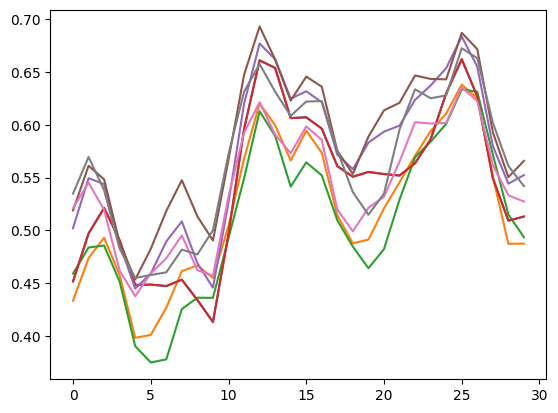

In [ ]:
plt.plot(input_arr[5,0:30,:])
print(input_arr[5,0:30,:])

In [ ]:
loaded_arr = np.load('dataset_EEG_M2.npz')

print("Loaded array:")
print("Input Shape : {} ".format(loaded_arr['input'].shape))
print("Output Shape : {} ".format(loaded_arr['labels'].shape))

Loaded array:
Input Shape : (3060, 640, 8) 
Output Shape : (3060,) 


# Training

In [ ]:
import numpy as np
import pandas as pd
import time
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LeakyReLU, Dense, Bidirectional, Activation, Flatten, Dropout, Input, TimeDistributed
from keras.layers import Conv2DTranspose, Conv2D, LSTM, BatchNormalization, MaxPooling2D, Reshape, RepeatVector
from keras.utils import to_categorical
from keras.regularizers import L1L2
from keras.initializers import lecun_uniform
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = "/content/drive/MyDrive/CourseWork/ENEE719D/GroupP1/dataset_EEG.npz"
# path = "/content/dataset_EEG_M2.npz"

loaded_arr = np.load(path)

print("Loaded array:")
print("Input Shape : {} ".format(loaded_arr['input'].shape))
print("Output Shape : {} ".format(loaded_arr['labels'].shape))

Loaded array:
Input Shape : (3060, 640, 8) 
Output Shape : (3060,) 


In [ ]:
input_seq = loaded_arr['input']
target_seq = loaded_arr['labels']

In [ ]:
# Define the percentage split for validation data
validation_split = 0.3  # 20% for validation

loaded_arr = np.load(path)

print("Loaded array:")
print("Input Shape : {} ".format(loaded_arr['input'].shape))
print("Output Shape : {} ".format(loaded_arr['labels'].shape))
print("Type of input : {}".format(type(loaded_arr['input'])))

input_seq = loaded_arr['input']
target_seq = loaded_arr['labels']

input_seq_r = np.reshape(input_seq, (input_seq.shape[0], 1, input_seq.shape[1], input_seq.shape[2]))
input_seq_r = np.reshape(input_seq, (input_seq.shape[0], 1, input_seq.shape[1]*input_seq.shape[2], 1))
target_seq_r = np.reshape(target_seq, (input_seq.shape[0],))


print("Loaded array:")
print("Input Shape : {} ".format(loaded_arr['input'].shape))
print("Output Shape : {} ".format(loaded_arr['labels'].shape))


# Perform a stratified split
# Perform a stratified split
X_train, X_test, y_train, y_test = train_test_split(input_seq_r, target_seq_r,
                                                    test_size=validation_split,
                                                    stratify=target_seq, random_state=4,
                                                    shuffle= True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=validation_split,
                                                  stratify=y_train, random_state=42,
                                                  shuffle = True)


# Define the choices
choices = np.array([0, 1, 2])

# Generate the random array
# y_val = np.random.choice(choices, size=(6912,))
# y_train = np.random.choice(choices, size=(27648,))

print("Train shapes {}".format(X_train.shape))
print("Validation shapes {}".format(X_val.shape))
print("Test shapes {}".format(X_test.shape))

Loaded array:
Input Shape : (3060, 640, 8) 
Output Shape : (3060,) 
Type of input : <class 'numpy.ndarray'>
Loaded array:
Input Shape : (3060, 640, 8) 
Output Shape : (3060,) 
Train shapes (1499, 1, 5120, 1)
Validation shapes (643, 1, 5120, 1)
Test shapes (918, 1, 5120, 1)


## LSTM

In [ ]:
loaded_arr['labels']
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Define the model
model = Sequential()

# model.add(TimeDistributed(Conv2D(filters=8,kernel_size=[1,20],
                                #  strides=(1, 2),activation='relu',
                                #  input_shape=(1, input_seq.shape[1], input_seq.shape[2]))))
# Encoder LSTM layer
model.add(LSTM(16, input_shape=( input_seq.shape[1], input_seq.shape[2])))

# TimeDistributed Dense layer to apply a Dense layer to each time step of the output sequence
model.add(Dense(3, activation='sigmoid'))  # Assuming single feature output

# model.add(TimeDistributed(Flatten()))
# Compile the model
model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])  # Using mean squared error loss for regression

model.build((None, 16, input_seq.shape[1], input_seq.shape[2]))
# Print the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1600      
                                                                 
 dense_6 (Dense)             (None, 3)                 51        
                                                                 
Total params: 1651 (6.45 KB)
Trainable params: 1651 (6.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
X_train.shape

(1499, 1, 5120)

In [ ]:
try:
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2], X_train.shape[3]))
  y_train = np.reshape(y_train, (y_train.shape[0],))
  X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[2], X_val.shape[3]))
  y_val = np.reshape(y_val, (y_val.shape[0],))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[2], X_test.shape[3]))
  y_test = np.reshape(y_test, (y_test.shape[0],))

except IndexError:
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2], 1))
  y_train = np.reshape(y_train, (y_train.shape[0],))
  X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[2], 1))
  y_val = np.reshape(y_val, (y_val.shape[0],))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[2], 1))
  y_test = np.reshape(y_test, (y_test.shape[0],))


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

EPOCHS =100
callbacks = [EarlyStopping(monitor='val_loss', patience=12), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]# uses validation set to stop training when it start overfitting
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=EPOCHS,callbacks=callbacks,batch_size=32, verbose=1, shuffle=True)

In [ ]:
model = load_model('./best_model.h5')
model.save('/content/drive/MyDrive/Dataset/Command_Words/best_model.h5')
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## TFlite Convertion

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io as sio
from matplotlib import pyplot
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras import models
from tensorflow import keras
import pandas as pd

from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython import display
from sklearn.metrics import f1_score

In [ ]:
MODELS_DIR = '/content/model/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [ ]:
loaded_arr = np.load('dataset_EEG_M2.npz')



Input_test = loaded_arr['input']
Label_test = loaded_arr['labels']

Input_test = np.reshape(Input_test, (input_seq.shape[0], 1, input_seq.shape[1], input_seq.shape[2]))
print("Loaded array:")
print("Input Shape : {} ".format(Input_test.shape))
print("Output Shape : {} ".format(Label_test.shape))

In [ ]:
model=load_model('/content/best_model.h5')
model.save(MODEL_TF)
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)
def representative_dataset():
  for i in range(500):
    yield([Input_test[i,:,:,:].reshape(1,Input_test.shape[2],Input_test.shape[3]).astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS, tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter._experimental_lower_tensor_list_ops = False
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

In [ ]:
x_test.size

In [ ]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  # x_test_ = x_test_.reshape((x_test.shape))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test_)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred


In [ ]:
# Calculate predictions with full software
y_pred = np.reshape(np.argmax(model.predict(Input_test.reshape(Input_test.shape[0], Input_test.shape[2],
                                                               Input_test.shape[3])), axis=1),[len(Input_test)])
y_true = Label_test

test_acc = float(sum(y_pred == y_true) / len(y_true))

print('Test accuracy with model:')
print(f"{test_acc:.2%}")
print("F1 score {}".format(f1_score(y_true, y_pred, labels=[0 , 1, 2], average=None)))


y_test_pred_no_quant_tflite=np.empty([Input_test.shape[0],1])
y_test_pred_tflite=np.empty([Input_test.shape[0],1])



# Calculate predictions with tensorflow lite
for i in range(0,Input_test.shape[0]):
  y_test_pred_no_quant_tflite[i,0]=np.argmax(predict_tflite(model_no_quant_tflite,
                                                            Input_test[i:i+1,0,:,:].reshape(1,Input_test.shape[2],Input_test.shape[3])))
y_test_pred_no_quant_tflite = np.reshape(y_test_pred_no_quant_tflite,[len(Input_test)])
test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))
print('Test accuracy with model tf lite:')
print(f"{test_acc:.2%}")
print("F1 score {}".format(f1_score(y_true, y_pred, average=None)))

In [ ]:
import zipfile
import os
from datetime import datetime

# Get current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
# Files or directories to be zipped
files_to_zip = ['/content/model', '/content/dataset_EEG_M2_test.npz',
                '/content/drive/MyDrive/Dataset/Command_Words/best_model.h5',
                '/content/drive/MyDrive/Colab Notebooks/Command_Word.ipynb']

# Path to save the zip file
zip_file_path = '/content/download_model_{}_{}.zip'.format(test_acc, timestamp)

# Create a zip archive
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for file in files_to_zip:
        if os.path.isdir(file):
            # If it's a directory, add its contents recursively
            for root, dirs, files in os.walk(file):
                for f in files:
                    zipf.write(os.path.join(root, f), arcname=os.path.relpath(os.path.join(root, f), os.path.join(file, '..')))
        else:
            zipf.write(file, arcname=os.path.basename(file))

## CNN

In [ ]:
model = tf.keras.Sequential()
# model.add(Conv2D(filters=8,kernel_size=[1,40],strides=(1, 2),activation='relu', input_shape=(1, input_seq.shape[1], input_seq.shape[2])))
model.add(Conv2D(filters=8,kernel_size=[1,40],strides=(1, 2),activation='relu', input_shape=(1, input_seq.shape[1]* input_seq.shape[2], 1)))
model.add(MaxPooling2D(pool_size=[1,2]))
# model.add(keras.layers.Dropout(0.001,  seed=10 ))
model.add(Conv2D(filters=8,kernel_size=[1,10],activation='relu'))
model.add(MaxPooling2D(pool_size=[1,2]))
model.add(Conv2D(filters=8,kernel_size=[1,10],activation='relu'))
# model.add(keras.layers.Dropout(0.001,  seed=10 ))
# model.add(layers.Conv2D(filters=1,kernel_size=[1,25],activation='relu'))
model.add(MaxPooling2D(pool_size=[1,2]))
model.add(Flatten())
model.add(Dense(3,activation='softmax'))
# model.add(keras.layers.Dropout(0.005,  seed=10 ))
#model.add(layers.Dropout(0.25))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 1, 2541, 8)        328       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 1, 1270, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 1, 1261, 8)        648       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 1, 630, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 1, 621, 8)         648       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 1, 310, 8)       

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(filters=4,kernel_size=[1,15],activation='relu', input_shape=(1, input_seq.shape[1], input_seq.shape[2])))
model.add(layers.MaxPooling2D(pool_size=[1,2]))
model.add(layers.Conv2D(filters=8,kernel_size=[1,9],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,2]))

model.add(layers.Conv2D(filters=8,kernel_size=[1,9],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,2]))
model.add(layers.Conv2D(filters=8,kernel_size=[1,5],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,2]))

model.add(layers.Conv2D(filters=16,kernel_size=[1,5],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,2]))

model.add(layers.Flatten())
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))
#model.add(layers.Dropout(0.25))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 1, 626, 4)         484       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 1, 313, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 1, 305, 8)         296       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 1, 152, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 1, 144, 8)         584       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 1, 72, 8)         

In [ ]:
def find_values(input_list, target_value):
    return [i for i, value in enumerate(input_list) if value == target_value]


target_value = 0
print(find_values(target_seq, target_value))
print(target_seq[4])

Train [1199  162  138]
Test [735  99  84]


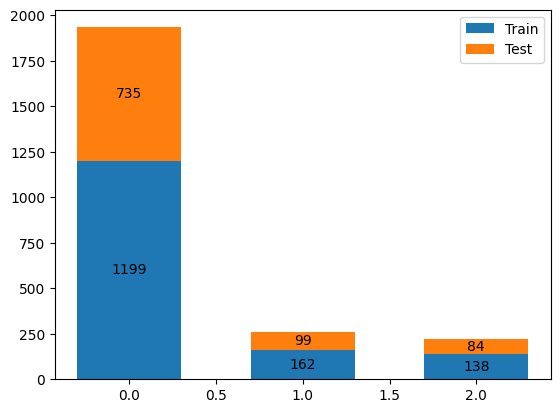

In [ ]:
# Plot each category
distribution = np.unique(target_seq)
train_test = {
    'Train': np.unique(y_train, return_counts=True)[1],
    'Test': np.unique(y_test, return_counts=True)[1],
}

fig, ax = plt.subplots()
bottom = np.zeros(3)

for train_test_i, train_test_count in train_test.items():
    print(train_test_i, train_test_count)
    p = ax.bar(distribution, train_test_count, 0.6, label=train_test_i, bottom=bottom)
    bottom += train_test_count

    ax.bar_label(p, label_type='center')

ax.legend()

plt.show()

In [ ]:

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

EPOCHS =100
callbacks = [EarlyStopping(monitor='val_loss', patience=12), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]# uses validation set to stop training when it start overfitting
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=EPOCHS,callbacks=callbacks,batch_size=32, verbose=1, shuffle=True)
# Save model
model.save("model")

Epoch 1/100
47/47 [==============================] - 3s 22ms/step - loss: 0.2570 - accuracy: 0.8786 - val_loss: 0.1491 - val_accuracy: 0.8911
Epoch 2/100
20/47 [===========>..................] - ETA: 0s - loss: 0.1388 - accuracy: 0.9125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 0s 11ms/step - loss: 0.1436 - accuracy: 0.8986 - val_loss: 0.1385 - val_accuracy: 0.8989
Epoch 3/100
47/47 [==============================] - 0s 9ms/step - loss: 0.1397 - accuracy: 0.9093 - val_loss: 0.1399 - val_accuracy: 0.9082
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: 0.1449 - accuracy: 0.8966 - val_loss: 0.1397 - val_accuracy: 0.9082
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: 0.1424 - accuracy: 0.9019 - val_loss: 0.1377 - val_accuracy: 0.9082
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: 0.1393 - accuracy: 0.9119 - val_loss: 0.1460 - val_accuracy: 0.9067
Epoch 7/100
47/47 [==============================] - 0s 7ms/step - loss: 0.1437 - accuracy: 0.8953 - val_loss: 0.1358 - val_accuracy: 0.9176
Epoch 8/100
47/47 [==============================] - 0s 6ms/step - loss: 0.2282 - accuracy: 0.8906 - val_loss: 0.1401 - val_accuracy: 0.9005
Epoch 9/100
47/47 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


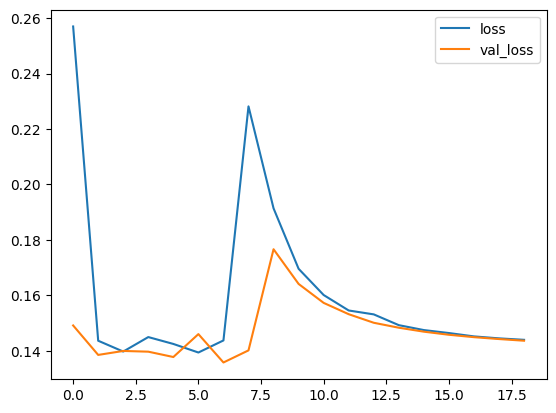

In [ ]:
model = load_model('/content/best_model.h5')
model.save('/content/drive/MyDrive/CourseWork/ENEE719D/best_model.h5')
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
np.savez('dataset_EEG_M2_test', input=X_test, labels=y_test)

In [ ]:
distribution_test = np.unique(y_test, return_counts=True)
distribution_train = np.unique(y_train, return_counts=True)
print(distribution_train)

(array([0., 1., 2.]), array([1199,  162,  138]))


In [ ]:
train_test

{'Train': array([1199,  162,  138]), 'Test': array([735,  99,  84])}

In [ ]:
np.unique(target_seq)

array([0., 1., 2.])

#TensorFlow Lite Converstion

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io as sio
from matplotlib import pyplot
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras import models
from tensorflow import keras
import pandas as pd

from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython import display
from sklearn.metrics import f1_score

In [ ]:
MODELS_DIR = '/content/model/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 1, 2541, 8)        328       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 1, 1270, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 1, 1261, 8)        648       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 1, 630, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 1, 621, 8)         648       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 1, 310, 8)       

In [ ]:
loaded_arr = np.load('dataset_EEG_M2.npz')



Input_test = loaded_arr['input']
Label_test = loaded_arr['labels']

Input_test = np.reshape(Input_test, (input_seq.shape[0], 1, input_seq.shape[1], input_seq.shape[2]))
print("Loaded array:")
print("Input Shape : {} ".format(Input_test.shape))
print("Output Shape : {} ".format(Label_test.shape))

Loaded array:
Input Shape : (3060, 1, 640, 8) 
Output Shape : (3060,) 


In [ ]:
model=load_model('/content/best_model.h5')
model.save(MODEL_TF)
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)
def representative_dataset():
  for i in range(Input_test.shape[0]):
    yield([Input_test[i,:,:,:].reshape(1,1,Input_test.shape[2],Input_test.shape[3]).astype(np.float32)])


def representative_dataset():
  for i in range(Input_test.shape[0]):
    yield([Input_test[i,:,:,:].reshape(1,1,Input_test.shape[2]*Input_test.shape[3],1).astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [ tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter._experimental_lower_tensor_list_ops = False
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)



14152

In [ ]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  #x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test_)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred


In [ ]:
loaded_arr['input'].shape

(3060, 640, 8)

In [ ]:
loaded_arr = np.load('dataset_EEG_M2_test.npz')



Input_test = X_train #loaded_arr['input']
Label_test = y_train #loaded_arr['labels']

Input_test = np.reshape(Input_test, (Input_test.shape[0], 1, Input_test.shape[2], Input_test.shape[3]))
print("Loaded array:")
print("Input Shape : {} ".format(loaded_arr['input'].shape))
print("Output Shape : {} ".format(loaded_arr['labels'].shape))


Loaded array:
Input Shape : (918, 1, 5120, 1) 
Output Shape : (918,) 


In [ ]:
# Calculate predictions with full software
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test)])
y_true = Label_test

test_acc = float(sum(y_pred == y_true) / len(y_true))

print('Test accuracy with model:')
print(f"{test_acc:.2%}")
print("F1 score {}".format(f1_score(y_true, y_pred, labels=[0 , 1, 2], average=None)))


y_test_pred_no_quant_tflite=np.empty([Input_test.shape[0],1])
y_test_pred_tflite=np.empty([Input_test.shape[0],1])



# Calculate predictions with tensorflow lite
for i in range(0,Input_test.shape[0]):
  y_test_pred_no_quant_tflite[i,0]=np.argmax(predict_tflite(model_no_quant_tflite,
                                                            Input_test[i:i+1,0,:,:].reshape(1,1,Input_test.shape[2],Input_test.shape[3])))
y_test_pred_no_quant_tflite = np.reshape(y_test_pred_no_quant_tflite,[len(Input_test)])
test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))
print('Test accuracy with model tf lite:')
print(f"{test_acc:.2%}")
print("F1 score {}".format(f1_score(y_true, y_test_pred_no_quant_tflite, average=None)))


47/47 [==============================] - 0s 2ms/step
Test accuracy with model:
92.13%
F1 score [1.         0.71219512 0.37894737]
Test accuracy with model tf lite:
92.13%
F1 score [1.         0.71359223 0.37234043]


In [ ]:
f1_score(y_true, y_pred, average=None)

array([1.        , 0.71219512, 0.37894737])

In [ ]:
# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,0]=np.argmax(predict_tflite(model_tflite,
                                                   Input_test[i:i+1,0,:,:].reshape(1,1,Input_test.shape[2],Input_test.shape[3])))

In [ ]:
y_test_pred_tflite =  np.reshape(y_test_pred_tflite,[len(Input_test)])
y_true = Label_test

test_acc = float(sum(y_test_pred_tflite == y_true) / len(y_true))
print('Test accuracy with model quantized:')
print(f"{test_acc:.2%}")
print("F1 score {}".format(f1_score(y_true, y_test_pred_tflite, average=None)))

Test accuracy with model quantized:
91.86%
F1 score [1.         0.71759259 0.27380952]


In [ ]:
f1_score(y_true, y_pred, average=None)

array([1.        , 0.71219512, 0.37894737])

In [ ]:

y_test_pred_tflite=np.empty([Input_test.shape[0],1])

# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,0]=np.argmax(predict_tflite(model_tflite,
                                                   Input_test[i:i+1,0,:,:].reshape(1,1,Input_test.shape[2],Input_test.shape[3])))
y_test_pred_tflite =  np.reshape(y_test_pred_tflite,[len(Input_test)])
y_true = Label_test

y_test_tflite = {"y_test_pred_tflite":y_test_pred_tflite}
sio.savemat('model/tflite_pred.mat',y_test_tflite)

In [ ]:
# Calculate size
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {0} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

Size                         
Model                                                           
TensorFlow Lite            17904 bytes      (reduced by 0 bytes)
TensorFlow Lite Quantized   14152 bytes  (reduced by 3752 bytes)

In [ ]:
# Calculate size
size_tflite = os.path.getsize(MODEL_TFLITE)
print(size_tflite)


# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

14152
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [ ]:
import zipfile
import os
from datetime import datetime

# Get current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
# Files or directories to be zipped
files_to_zip = ['/content/model', '/content/dataset_EEG_M2_test.npz',
                '/content/drive/MyDrive/CourseWork/ENEE719D/best_model.h5']

# Path to save the zip file
zip_file_path = '/content/download_model_{}_{}.zip'.format(test_acc, timestamp)

# Create a zip archive
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for file in files_to_zip:
        if os.path.isdir(file):
            # If it's a directory, add its contents recursively
            for root, dirs, files in os.walk(file):
                for f in files:
                    zipf.write(os.path.join(root, f), arcname=os.path.relpath(os.path.join(root, f), os.path.join(file, '..')))
        else:
            zipf.write(file, arcname=os.path.basename(file))

In [ ]:
print(zip_file_path)

/content/download_model_0.9186124082721815_2024-03-12_01-57.zip
